# Example notebook for import-export operations with pyMOE

In the following is exemplified how to: 
* Transform a (multi-layer) .gds file into a grayscale image file (allowed extensions as accepted by opencv, e.g. .tiff, .png, .jpg ...)
* Transform a grayscale image file into a dithered image file
* Transform a grayscale image file (.tiff, .png, ...) into a gds file (with  squared pixels) 
* Extra: Merge all pixels (or shapes) in a layer inside a .gds file 

In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}


import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 


## Export a created mask using gdsconverter

<IPython.core.display.Javascript object>


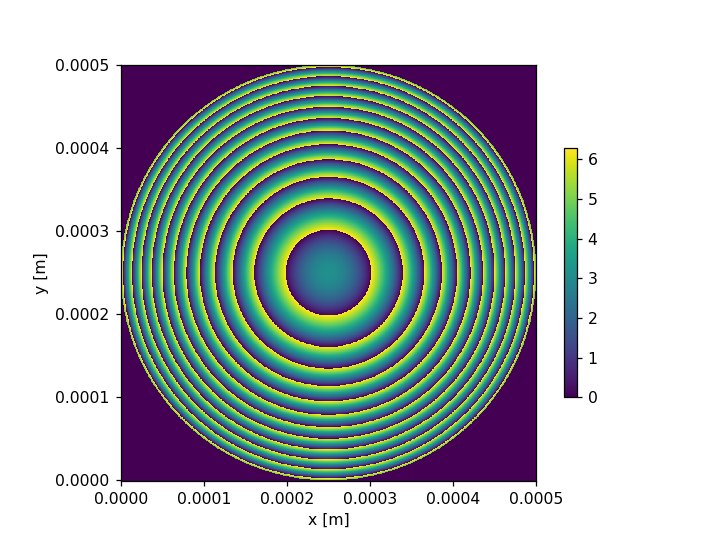

<IPython.core.display.Javascript object>


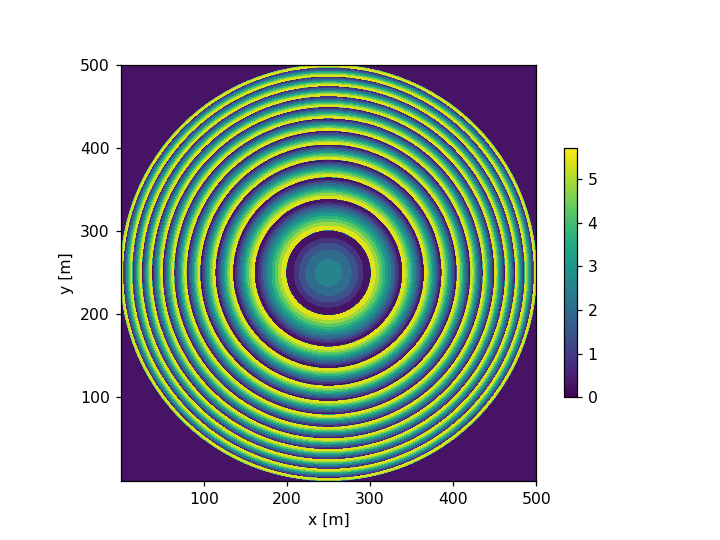

In [2]:
###Here we create a gds file using the generate and the gdsconverter modules 

####generate a fresnel phase mask and save it into gds 
npix =1000 # nr of pixels 
foc = 5000 # focal distance in um 
lda = 0.532 #wavelength in um 
xsiz = 500 #x-size in um
ysiz = 500 #y-size in um
n = 10  # number of gray levels 
gdsname = 'fresnel_phase_mask.gds' # name of gds file


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture = moe.generate.create_empty_aperture(0, xsiz*micro, npix, 0, ysiz*micro, npix-1)

center = (250*micro, 250*micro)

# and truncate around radius
mask = moe.generate.fresnel_phase(aperture, foc * micro, lda * micro, radius=xsiz/2*micro, center = center)
moe.plotting.plot_aperture(mask )

#discretize the mask to all levels  and plot dicretied mask 
mask.discretize(n+1)
moe.plotting.plot_aperture(mask ) 



In [3]:
#initialize the GDS converter class 
gdsmask = moe.GDSMask(mask)

# Create layout and merge polygons together if merge=True 
#contour mode is faster but not very exact for low resolutions
gdsmask.create_layout(mode = "contour", merge=True)

gdsmask.write_gds(gdsname)


Creating contours 
[Create Contours]
Elapsed: 0:00:00.588041
Passing contours into GDS. 
0
1
2
3
4
5
6
7
8
9
[Total time converting to GDS]
Elapsed: 0:00:03.605012
Saved fresnel_phase_mask.gds


## Transform layered .gds file into a grayscale image

<IPython.core.display.Javascript object>


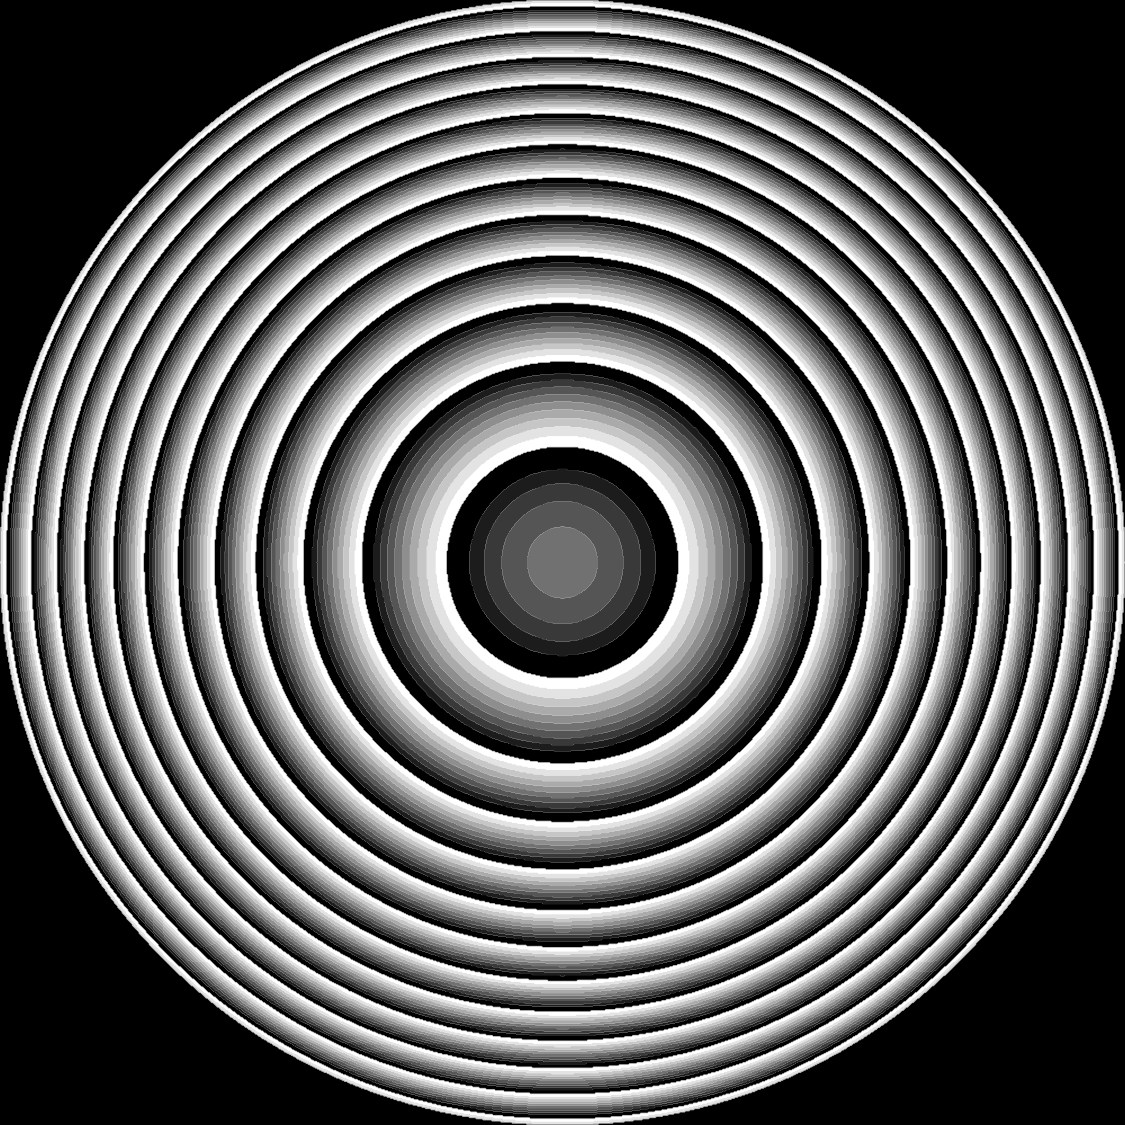

228 polygons found...
Layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Datatypes: [0]
xmax is 1000.0
ymax is 1000.0
xmin is 0.0
ymin is 0.0
Imported file fresnel_phase_mask.gds and exported into fresnel_phase_mask.bmp with size 1000 x 1000 pixels.


In [4]:
##Start with an existing file 
#Might take a while 
infile = "fresnel_phase_mask.gds"
outfile = "fresnel_phase_mask.bmp"
n=10

moe.importing.gds2img(infile, outfile, int(n-1),  rescaled=npix/xsiz, verbose=True)


## Transform grayscale image into (binary) dithered image 

<IPython.core.display.Javascript object>


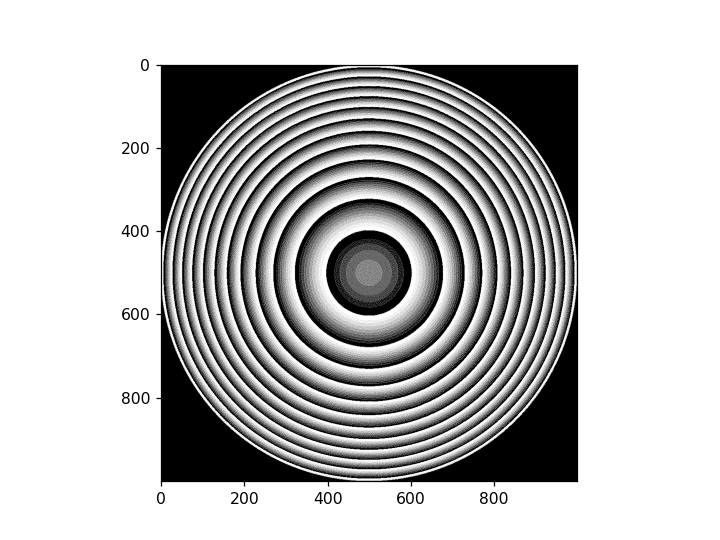

In [5]:
##Make a dithered mask from the tiff obtained from the gds 
import pyMOE.dither as dith

inputimg = "fresnel_phase_mask.bmp"
ditherimg = "fresnel_phase_mask_ditherx.tiff"

#make dithering using the floyd steinberg algorithm now
moe.dither.dither_img(inputimg, ditherimg, plotting=True)

## Transform binary image file into single layered .gds file

Transform a dithered image into a gds file, using a fractioning of the image


In [6]:
infilxe = "fresnel_phase_mask_ditherx.tiff"
outfilxe = "fresnel_phase_mask_frac.gds"
pixelx = 1 #um 
pixely = 1 #um 
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
frac = 250 #size of frac pixels in the image 

moe.export.grayim2gds_writer_frac(infilxe, outfilxe, pixelx, pixely, cellname, graycolor, frac, verbose=False)

Sucessfully imported img!
1000
1000
[   0  250  500  750 1000]
0
0
250
500
750
250
0
250
500
750
500
0
250
500
750
750
0
250
500
750
17
Exported the image file fresnel_phase_mask_ditherx.tiff into fresnel_phase_mask_frac.gds


Transform a dithered image into a .gds file, using the whole image 

In [7]:
infilxe = "fresnel_phase_mask_ditherx.tiff"
outfilxe = "fresnel_phase_mask_dithered.gds"
cellname = "TOP" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

Sucessfully imported img!
1000
1000
Exported the image file fresnel_phase_mask_ditherx.tiff into fresnel_phase_mask_dithered.gds


In [8]:
###Using instances to create the dithered gds file (faster and less heavy files)

#(Takes less than 1 min)
infilxe = "fresnel_phase_mask_ditherx.tiff"
outfilxe = "fresnel_phase_mask_dithered_instances.gds"
cellname = "tops" #name of the gds cell 
graycolor = 0 #black pixels 
pixelx = 1 #um 
pixely = 1 #um 

moe.export.grayim2gds_writer_klops(infilxe, outfilxe, pixelx, pixely,cellname, graycolor, verbose=False)

Sucessfully imported img!
1000
1000
Exported the image file fresnel_phase_mask_ditherx.tiff into image.gds
Starting making instances
Done


## Extra: Merging shapes in the single layer .gds file 

The "pixelated" gds files (without instances) are typically large. The file size can be reduced by merging the pixels - the merge operation can be done using the gds_klops module

In [9]:
import pyMOE.gds_klops as gdsops 

inputfile = "fresnel_phase_mask_dithered.gds"
outputfile = "fresnel_phase_mask_dithered+merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )

Merged layers in fresnel_phase_mask_dithered+merged.gds


In [10]:
#uses the instatiated gds 
inputfile = "fresnel_phase_mask_dithered_instances.gds"
outputfile = "fresnel_phase_mask_dithered_instances+merged.gds"
cellname = "TOP" #name of the gds cell 
layer = int(0)
datatype = int(0)

moe.gdsops.merge_layer(inputfile,cellname, layer, datatype ,outputfile )

Merged layers in fresnel_phase_mask_dithered_instances+merged.gds


In [11]:
#